# Perceptron and SVM

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/notebooks/Lab-8.Perceptron_and_SVM.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA
import itertools as it

## Dataset
We'll be using a binary data set in a 2-dimensional space where each point is labeled either 1 or -1 based on whether it falls above or below a straight line, whose equation is $y = ax+b$.

1. **Define a function which generates this set of data points.**

In [19]:
x = np.random.uniform(1,10,6)
y = np.random.uniform(1,10,6)
x = np.array(list(zip(x,y)))
x.shape

(6, 2)

In [13]:
def binary(a: int, b: int, npoints: int, xlim: list[float], ylim: list[float]) -> tuple[np.array]:
    """
    Generates a set of points randomly in the rectangle defined by lb and ub, 
    label them using the equation y = ax + b, 
    
    Parameters:
        a (int): The coefficient of x in the line equation.
        b (int): The intercept of the line equation.
        npoints (int): The number of points to generate.
        xlim (list[float]): Interval on x axis to generate points within.
        ylim (list[float]): Interval on y axis to generate points within.
    
    Returns:
        tuple[np.array, np.array] Arrays of points and labels
    """
    x = np.random.uniform(xlim[0],xlim[1],npoints)
    y = np.random.uniform(ylim[0],ylim[1],npoints)
    x = np.array(list(zip(x,y)))
    labels = [1 if a*xi+b >= yi else -1 for xi,yi in x]
    return x, labels
    

    # return X, labels    

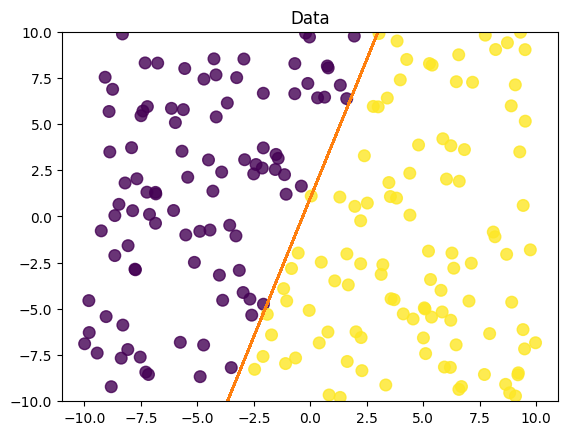

In [44]:
a = 3
b = 1
npoints = 200
xlim = [-10,10]
ylim = [-10,10]

X, labels = binary(a,b,npoints,xlim,ylim)

plt.scatter(X[:,0], X[:,1], s=70, c=labels, alpha=0.8)
plt.plot(X, a*X+b)
plt.ylim(ylim)
plt.title('Data')
plt.show()

In [45]:
print(X)

[[-7.52778377 -7.61010226]
 [-7.30986436  8.30920461]
 [-4.16329081  5.38616789]
 [ 7.70680441 -8.55129364]
 [ 9.18930822 -8.56608992]
 [-8.31423526  9.87741364]
 [ 3.13746545 -3.13282447]
 [ 0.83309293 -9.65910256]
 [ 2.02368656 -6.24183854]
 [-8.65102871  0.04896886]
 [-5.61942239  5.78231305]
 [ 9.96918685 -6.83324639]
 [ 9.48334336 -7.16567754]
 [ 4.54966763 -5.54703075]
 [-1.09451169 -7.9591706 ]
 [-0.68663951  6.64301101]
 [-0.03525626  9.7111454 ]
 [ 1.63434274 -7.84669305]
 [ 3.81784449  0.99413034]
 [ 2.78736851  5.95522125]
 [ 3.5747705  -4.45079474]
 [-7.91018006  3.72294995]
 [ 1.97154669  0.54777551]
 [-9.78474944 -6.28195638]
 [-3.49825417 -8.17878585]
 [-7.16266839 -8.55057668]
 [-7.73927734 -2.88346755]
 [-0.20912346  9.92052326]
 [-5.97122963  5.0823234 ]
 [-1.51689778  3.35803536]
 [ 1.32142575 -9.79154775]
 [-5.75361186 -6.80984109]
 [ 6.2694503  -1.97904899]
 [ 6.34983005 -2.79852146]
 [ 7.12498103 -2.52936736]
 [-1.14051079  2.26289617]
 [-5.13026208 -2.48340485]
 

## Perceptron online algorithm
The perceptron online algorithm is a binary classification algorithm that is used to train a linear classifier. It is a type of online learning algorithm, which means that it updates the model parameters after observing each training example, instead of waiting to see all the examples at once (as in batch learning).

Step-by-step explanation: 
1. Initialize the model parameters: The algorithm starts by setting the weights $w$ and bias $b$ to small random values. These weights define the hyperplane that separates the points.
2. Process each training example: For each training example (x, label), the algorithm does the following:
  -  Compute the predicted label: The algorithm computes the dot product of the weight vector $w$ and the feature vector $x$,  adds the bias term $b$, and applies the sign function to get the predicted label $y_{pred}=sgn(w^{T}x +b)$.
  - Update the model parameters: If the predicted label is incorrect, the algorithm updates the weight vector and bias term. This update rule adjusts the weight vector in the direction of the misclassified example to try to correctly classify it in future iterations, according to a learning rate $\eta$.
3. Repeat step 2 until convergence: The algorithm continues to process each training example, updating the model parameters as necessary, until it reaches a stopping criterion. One common stopping criterion is to stop after a fixed number of iterations or when the misclassification rate on a validation set falls below a certain threshold.
4. Return the learned model parameters: Once the algorithm has converged, it returns the final weight vector, which can be used to classify new examples by computing the dot product of the feature vector and weight vector, adding the bias term, and applying the sign function.



Pseudocode:

$$
\textrm{if}\;\; y_{i}(w^{T}x_{i} +b)<0 \quad \textrm{then} \quad
\begin{cases}
w_{t+1}=w_{t}+\eta y_{i}x_{i} \\
b_{t+1} = b_t + \eta y_i\\
\end{cases}
$$
$$
\textrm{else}\quad
\begin{cases}
w_{t+1}=w_{t} \\
b_{t+1} = b_t
\end{cases}
$$


2. **Write an iteration of the Perceptron algorithm.**

In [20]:
def Perceptron(x: np.array, labels: np.array, eta: float) -> tuple[np.array,float]:
    """
    Performs a single iteration of the Perceptron learning algorithm for binary classification.

    Parameters:
        x (np.array): A 2D NumPy array where each row represents a data point and each column a feature.
        labels (np.array): A 1D NumPy array containing the class labels (either -1 or 1).
        eta (float): The learning rate for weight updates.

    Returns:
        tuple[np.array, float]: A tuple containing:
            - A NumPy array representing the updated weight vector.
            - A float representing the updated bias term.
    """
    W = np.random.uniform(-0.1,0.1,x.shape[1])
    B = np.random.uniform(-0.1,0.1,1)
    for i,point in enumerate(x):
        if (np.dot(W,point)+b) * labels[i] < 0:
            W = W+eta*labels[i]*point
            B = B + eta*labels[i]

    return W, B

In [21]:
eta = 1
W, B = Perceptron(X,labels,eta)

# final weights
print(W)
print(B)

[17.43281432 -5.12528639]
[-0.06538789]


## Plot the separator
To visualise the performance of the Perceptron, let's plot the data points in a scatter plot like earlier, and the separator line computed by the algorithm. 

The equation of the separator line is given by

$$
w^T x + b=0\;\;\rightarrow\;\;w_{1}x_{1}+w_{2}x_{2} +b =0\;\;\rightarrow\;\;x_{2}=-\frac{w_{1}}{w_{2}}x_{1} - \frac{b}{w_2}
$$

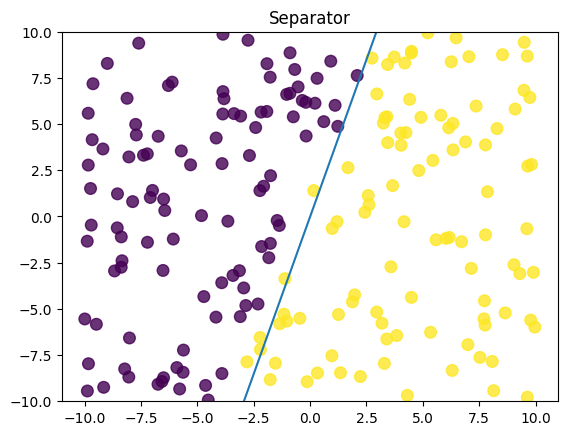

In [22]:
# x-coordinates of the separator line
x = np.linspace(xlim[0], xlim[1],100)
# corresponding y-coordinates of the separator line
y = -(W[0]/W[1]) *x - (B/W[1])

plt.scatter(X[:,0],X[:,1],s=70, c=labels, alpha=0.8)
plt.plot(x,y)
plt.title('Separator')
plt.ylim(ylim)
plt.show()

In [23]:
# compute the absolute distance between the true slope of the separator and the computed one, and for the intercept
print(np.abs(a-(-W[0]/W[1])))
print(np.abs(b-(-B/W[1])))

0.4013346722971467
[1.0127579]


### Ready-made functions for the Perceptron
- [Scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html)

In [24]:
from sklearn import linear_model

perc = linear_model.Perceptron()
# Fit linear model with Stochastic Gradient Descent
perc.fit(X, labels)

# extract weights and bias
wperc = perc.coef_[0]
bperc = perc.intercept_[0]
print(wperc)
print(bperc)

[ 30.97178664 -10.99849572]
11.0


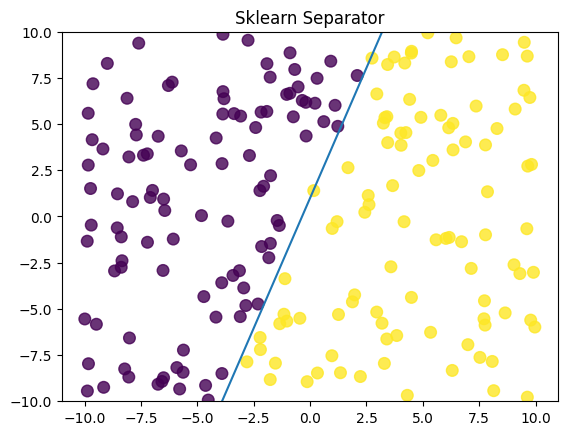

In [25]:
# x-coordinates of the separator line
x = np.linspace(xlim[0], xlim[1],100)
# corresponding y-coordinates of the separator line
y = -wperc[0]/wperc[1] *x - (bperc/wperc[1])

plt.scatter(X[:,0],X[:,1],s=70, c=labels, alpha=0.8)
plt.plot(x,y)
plt.title('Sklearn Separator')
plt.ylim(ylim)
plt.show()


## Linear Support Vector Machines

see also: https://ee227c.github.io/code/lecture4.html



Suppose we have a linear classification problem with data $(x_{i},y_{i})^{M}_{i=1}$  and we wish to find a hyperplane 
determined  by the vector $w$ such that

$$
\begin{cases}
w^{T}x\geq 1\;\;\;\textrm{when}\;\;\;y_{i}=1 \\
w^{T}x\leq -1\;\;\;\textrm{when}\;\;\;y_{i}=-1 \\
\end{cases}
$$

By the theory we know that the smaller the norm $\|w\|$  the larger the margin between positive and negative instances. 
Therefore, it makes sense to throw in a regularizer that penalizes large norms. This leads to the objective.

$$
L(w)=\frac{1}{M}\sum_{i=1}^{M} \max(1−y_{i}(w^{T}x_{i}),0)+ \lambda \|w\|^{2}_{2}
$$

**PAY ATTENTION**

In the formulation we have we miss the bias term. How we can modify our data to include (implicitly) the bias into the weights


In [51]:
#modify in someway X we need something filled with ones, why?
bias = np.ones((X.shape[0],1))
X = np.hstack((X,bias))
print(X)

[[-7.52778377 -7.61010226  1.        ]
 [-7.30986436  8.30920461  1.        ]
 [-4.16329081  5.38616789  1.        ]
 [ 7.70680441 -8.55129364  1.        ]
 [ 9.18930822 -8.56608992  1.        ]
 [-8.31423526  9.87741364  1.        ]
 [ 3.13746545 -3.13282447  1.        ]
 [ 0.83309293 -9.65910256  1.        ]
 [ 2.02368656 -6.24183854  1.        ]
 [-8.65102871  0.04896886  1.        ]
 [-5.61942239  5.78231305  1.        ]
 [ 9.96918685 -6.83324639  1.        ]
 [ 9.48334336 -7.16567754  1.        ]
 [ 4.54966763 -5.54703075  1.        ]
 [-1.09451169 -7.9591706   1.        ]
 [-0.68663951  6.64301101  1.        ]
 [-0.03525626  9.7111454   1.        ]
 [ 1.63434274 -7.84669305  1.        ]
 [ 3.81784449  0.99413034  1.        ]
 [ 2.78736851  5.95522125  1.        ]
 [ 3.5747705  -4.45079474  1.        ]
 [-7.91018006  3.72294995  1.        ]
 [ 1.97154669  0.54777551  1.        ]
 [-9.78474944 -6.28195638  1.        ]
 [-3.49825417 -8.17878585  1.        ]
 [-7.16266839 -8.55057668

The hinge loss function is not differentiable everywhere. Solution: subgradient optimisation!

In [52]:
# loss function
def hingeFunction(z: np.array) -> np.array:
    """
    Computes the hinge loss for a given input array.

    The hinge loss is defined as:
        max(1 - z, 0)
    It is commonly used in support vector machines (SVMs) for classification.

    Parameters:
        z (np.array): A NumPy array containing input values.

    Returns:
        np.array: A NumPy array containing the hinge loss values for each input.
    """
    return np.maximum(1-z,0)


def hingesubgrad(z: np.array) -> np.array:
    """
    Computes the subgradient of the hinge loss function.

    The hinge loss is defined as:
        max(1 - z, 0)
    Its subgradient is:
        -1 if z < 1, otherwise 0

    This function is useful in optimization methods such as subgradient descent for training 
    Support Vector Machines (SVMs).

    Parameters:
        z (np.array): A NumPy array containing input values.

    Returns:
        np.array: A NumPy array containing the subgradient values for each input.
    """
    g = np.zeros(z.shape)
    g[z < 1] = -1
    return g

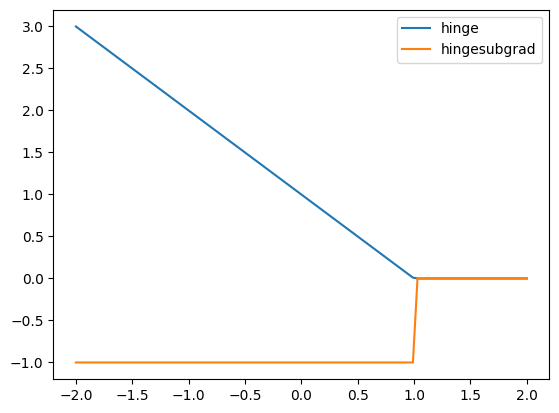

In [53]:
# Visualise these two functions
z = np.linspace(-2, 2, 100)
plt.plot(z, hingeFunction(z), label = 'hinge')
plt.plot(z, hingesubgrad(z), label = 'hingesubgrad')
plt.legend()

Now we can define our objective.

In [54]:
def ReghingeLoss(X: np.array, labels: np.array, w: np.array, lam: float) -> float:
    """
    Computes the regularized hinge loss for a given dataset and weight vector.

    The regularized hinge loss is defined as:
        L = (1/n) * sum(max(1 - labels * (X @ w), 0)) + λ ||w||_2
    where:
        - The first term represents the average hinge loss across all data points.
        - The second term is an L2 regularization term to maximize the margin.

    Parameters:
        X (np.array): A 2D NumPy array of shape (d, n), where each column is a feature vector.
        labels (np.array): A 1D NumPy array of shape (d,) containing class labels (either -1 or 1).
        w (np.array): A 1D NumPy array representing the weight vector.
        lam (float): The regularization parameter (lambda), controlling the strength of regularization.

    Returns:
        float: The computed regularized hinge loss.
    """
    d = np.shape(X)[0]
    L = np.mean(np.maximum(np.ones(d) - labels*(X@w), 0)) + lam * np.linalg.norm(w,2) 
    return L

In [55]:
def svmGrad(X: np.array, labels: np.array, w: np.array, lam: np.array) -> np.array:
    """
    Computes the gradient of the regularized hinge loss for Support Vector Machines (SVM).

    The gradient is given by:
        ∇L = (hinge subgradient) * (labels * X) + 2 * λ * w

    where:
    - The first term represents the gradient contribution from the hinge loss.
    - The second term accounts for the L2 regularization.

    Parameters:
        X (np.array): A 2D NumPy array of shape (d, n), where each column is a feature vector.
        labels (np.array): A 1D NumPy array of shape (d,) containing class labels (-1 or 1).
        w (np.array): A 1D NumPy array representing the weight vector.
        lam (float): The regularization parameter controlling the strength of regularization.

    Returns:
        np.array: A NumPy array representing the gradient of the loss function with respect to w.
    """
    g1 = hingesubgrad(np.diag(labels)@(X@w))
    g2 = np.diag(labels)@X
    return g1.dot(g2) + 2*lam*w

3. **Implement an SVM training function.**

In [56]:
def svm_training(X: np.array, labels: np.array, lam: float, niter: int, gamma: float) -> tuple[np.array]:
    """
    Trains a Support Vector Machine (SVM) using subgradient descent.

    This function minimizes the regularized hinge loss using an iterative optimization approach.

    Parameters:
    X (np.array): A 2D NumPy array of shape (d, n), where each column represents a feature vector.
    labels (np.array): A 1D NumPy array of shape (d,) containing class labels (-1 or 1).
    lam (float): The regularization parameter controlling the strength of regularization.
    niter (int): The number of iterations for the optimization process.
    gamma (float): The learning rate for weight updates.

    Returns:
        np.array: A 1D NumPy array representing the trained weight vector.
        np.array: A 1D NumPy array of all the losses through the traininig
    """
    w = np.zeros(X.shape[1])
    losses = []
    
    for i in range(niter):
        grad = svmGrad(X, labels, w, lam)
        w = w - gamma * grad
        loss = ReghingeLoss(X, labels, w, lam)
        losses.append(loss)
    
    return w, losses
    

In [57]:
W, L = svm_training(X, labels, lam=0, niter=2000, gamma=0.0001)

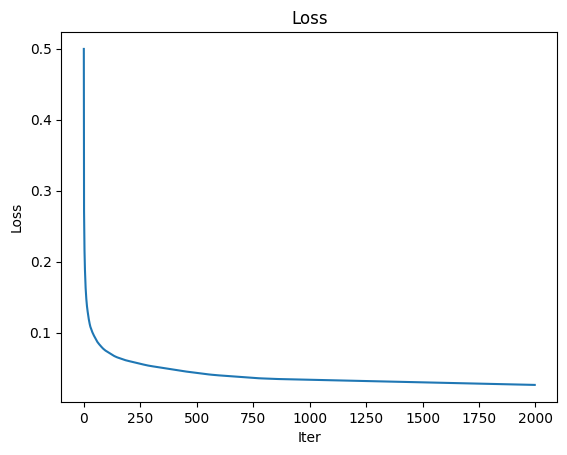

In [58]:
# plot loss

fig, ax = plt.subplots()
ax.plot(L[0:-2])
ax.set_title('Loss')
ax.set_xlabel('Iter')
ax.set_ylabel('Loss')

plt.show()

In [59]:
# get SVM's predictions
def predlabels(X, w):    
    return np.sign(X@w)

# calculate accuracy
def acc(labels, predlabels):
     return np.count_nonzero(labels == predlabels)/len(labels)   

In [60]:
pred = predlabels(X,W)
acc(labels,pred)

1.0

In [61]:
# final weights
print(W)

[ 1.59554654 -0.52390068  0.5995    ]


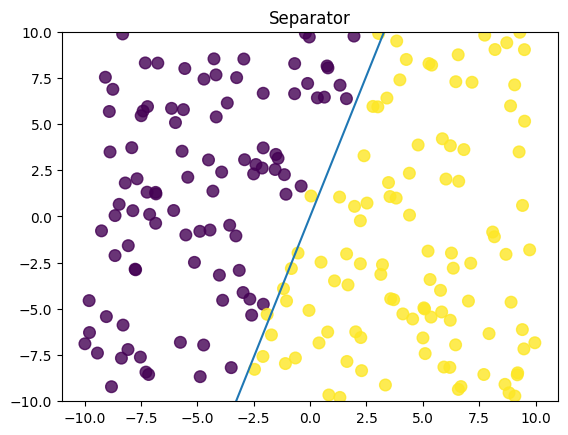

In [62]:
# x-coordinates of the separator line
x = np.linspace(xlim[0], xlim[1],100)
# corresponding y-coordinates of the separator line
y = -(W[0]/W[1]) *x 

plt.scatter(X[:,0],X[:,1],s=70, c=labels, alpha=0.8)
plt.plot(x,y)
plt.title('Separator')
plt.ylim(ylim)
plt.show()

### Ready-made functions for SVM
- [Scikit learn](https://scikit-learn.org/stable/modules/svm.html#classification)

In [63]:
from sklearn.svm import LinearSVC

svc = LinearSVC().fit(X, labels)
svc.score(X, labels)

1.0

4. **Redo everything introducing noise in the labels**

In [86]:
idx_nois = np.random.choice(len(labels), int(len(labels) * 0.1), replace=False)
idx_nois = idx_nois.flatten()
idx_nois = idx_nois.astype(int)
label_noisy = labels.copy()
for i in idx_nois:
    label_noisy[i] = -label_noisy[i]

[15.79975708 -1.21394829 -3.        ]
-3.0


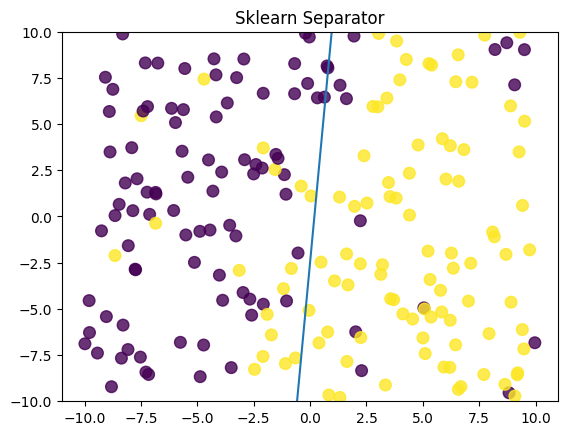

In [88]:
from sklearn import linear_model

perc = linear_model.Perceptron()
# Fit linear model with Stochastic Gradient Descent
perc.fit(X, label_noisy)

# extract weights and bias
wperc = perc.coef_[0]
bperc = perc.intercept_[0]
print(wperc)
print(bperc)

x = np.linspace(xlim[0], xlim[1],100)
# corresponding y-coordinates of the separator line
y = -wperc[0]/wperc[1] *x - (bperc/wperc[1])

plt.scatter(X[:,0],X[:,1],s=70, c=label_noisy, alpha=0.8)
plt.plot(x,y)
plt.title('Sklearn Separator')
plt.ylim(ylim)
plt.show()

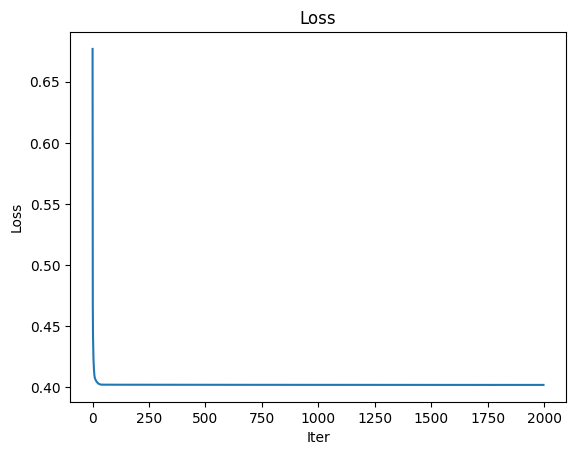

0.985
[ 0.28704047 -0.11125977  0.0777    ]


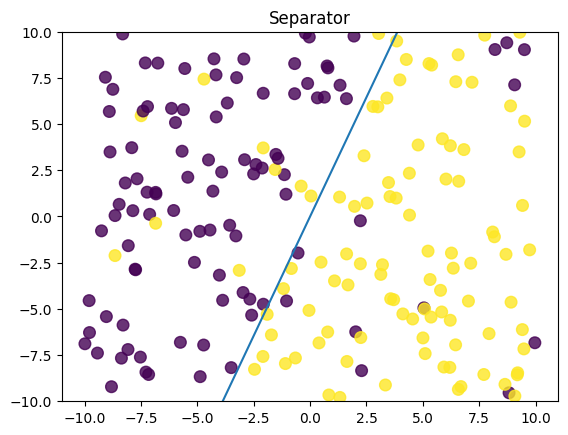

In [91]:
W, L = svm_training(X, label_noisy, lam=0, niter=2000, gamma=0.0001)

fig, ax = plt.subplots()
ax.plot(L[0:-2])
ax.set_title('Loss')
ax.set_xlabel('Iter')
ax.set_ylabel('Loss')
plt.show()

pred = predlabels(X,W)
print(acc(labels,pred))
print(W)

x = np.linspace(xlim[0], xlim[1],100)
y = -(W[0]/W[1]) *x 
plt.scatter(X[:,0],X[:,1],s=70, c=label_noisy, alpha=0.8)
plt.plot(x,y)
plt.title('Separator')
plt.ylim(ylim)
plt.show()
